OBJECTIVE: BUILD A CLASSIFIER FOR NEWS: FALSE OR TRUE

In [113]:
# libraries importation

    # to load data
    
    import pandas as pd
    import numpy as np
    
    # to clean data

    import re
    import string
    import nltk
    from nltk import sent_tokenize, word_tokenize
    from nltk.stem import WordNetLemmatizer
    from nltk.corpus import stopwords
    from nltk.probability import FreqDist
    from nltk.corpus import names

    # to visualize and explore data

    import matplotlib.pyplot as plt
    %matplotlib inline
    import itertools
    import plotly
    from wordcloud import WordCloud
    
    # to make train / test split
    import random
    from sklearn.model_selection import train_test_split
    
    # to vectorize text
    
    from sklearn.feature_extraction.text import CountVectorizer
    from sklearn.feature_extraction.text import TfidfVectorizer
    from sklearn.feature_extraction.text import HashingVectorizer
    
    # to classify news
    from sklearn.naive_bayes import MultinomialNB
    from sklearn.linear_model import PassiveAggressiveClassifier
    from sklearn.linear_model import LogisticRegression
    from sklearn.svm import LinearSVC
    
    # to measuere our classification
    
    import sklearn.metrics 
    from sklearn.metrics import accuracy_score
    
    # to save model
    
    import pickle
    
    







LOADING THE DATASET: NEWS (you can see the dataset building process in the next jupyter notebool:
                          news_scraping.ipynb, in the same directory as the actual)

In [2]:
news = pd.read_csv('./data/news_dataset.csv', index_col=0)

EXPLORATORY DATA ANALYSIS

In [3]:
# Exploring the dataset.
news.head()

,author,body,h1,h2,label,url
0,NaN,Ojalá una bomba ahora en Colón. ¿Donde están l...,"Pablo Iglesias borra un tuit: ""Ojalá una bomb...",NaN,False,http://elmetropolitanodemadrid.blogspot.com/20...
1,TransMurcia,En una comparecencia digna del Club de la Come...,El Partido Popular acapara el 86% del coste po...,NaN,False,http://murciatransparente.net/partido-popular-...
2,NaN,"Según informa el digital El Cadenazo, la alcal...",Manuela Carmena se ha convertido recientemente...,NaN,False,http://www.12minutos.com/5c255a4e64b9a/manuela...
3,NaN,Si en nuestra última noticia anunciábamos la p...,NUEVO RADAR DE TRAFICO INVISIBLE. COMPÁRTELO!,Llega a España el radar ‘invisible’. Tráfico p...,False,http://www.aldeaviral.com/nuevo-radar-de-trafi...
4,Miguel Ruiz,"El líder del PP dice que ""haré lo posible para...",Pablo Casado: haré lo posible para impedir que...,NaN,False,http://viraladvertising.over-blog.com/2018/11/...


How is our dataframe?

In [4]:
news.shape

(762, 6)

Look at the variables and their types

In [5]:
news.dtypes

author    object
body      object
h1        object
h2        object
label       bool
url       object
dtype: object

Identify the columns with missing values.

In [6]:
null_cols = news.isnull().sum()
null_cols


author     32
body        9
h1          3
h2        185
label       0
url         0
dtype: int64

In [7]:
# We "correct" the nulls value, adding the word 'empty'

news = news.fillna('empty')

In [8]:
# Looking for null columns again: 
null_cols = news.isnull().sum()
null_cols

author    0
body      0
h1        0
h2        0
label     0
url       0
dtype: int64

FEATURE CREATION


We build two new columns:

    - new_structure
    - body length

    new_structure:      value 1 (if the new has the traditional strcture: headline, subheadline, 
                                 body and author) or 
                        value 0 (if there is an 'empty' value in one of these columns).

    body length:        the length of the new's body in number of character. 

In [9]:
# body_length creation

news['bodylength'] = [len(x) for x in news['body']]

In [10]:
# Numeric statistic description of bodylength as our unique numeric column 

news.bodylength.describe()

count      762.000000
mean      3284.653543
std       2356.264174
min          5.000000
25%       1482.250000
50%       2723.000000
75%       4457.250000
max      17834.000000
Name: bodylength, dtype: float64

In [16]:

# new_structure = [0 for row in news if news.isin({'Author': ['empty'], 'h1': ['empty'], 'h2': ['empty'], 'body': ['empty']}) else 1]

news['new_structure'] = (news == 'empty').any(axis=1)
news['new_structure'] = np.where((news['new_structure']== True), 0,1)

In [17]:
# How news looks like after the change
news.head()

,author,body,h1,h2,label,url,bodylength,new_structure
0,empty,Ojalá una bomba ahora en Colón. ¿Donde están l...,"Pablo Iglesias borra un tuit: ""Ojalá una bomb...",empty,False,http://elmetropolitanodemadrid.blogspot.com/20...,84,0
1,TransMurcia,En una comparecencia digna del Club de la Come...,El Partido Popular acapara el 86% del coste po...,empty,False,http://murciatransparente.net/partido-popular-...,2294,0
2,empty,"Según informa el digital El Cadenazo, la alcal...",Manuela Carmena se ha convertido recientemente...,empty,False,http://www.12minutos.com/5c255a4e64b9a/manuela...,777,0
3,empty,Si en nuestra última noticia anunciábamos la p...,NUEVO RADAR DE TRAFICO INVISIBLE. COMPÁRTELO!,Llega a España el radar ‘invisible’. Tráfico p...,False,http://www.aldeaviral.com/nuevo-radar-de-trafi...,1133,0
4,Miguel Ruiz,"El líder del PP dice que ""haré lo posible para...",Pablo Casado: haré lo posible para impedir que...,empty,False,http://viraladvertising.over-blog.com/2018/11/...,564,0


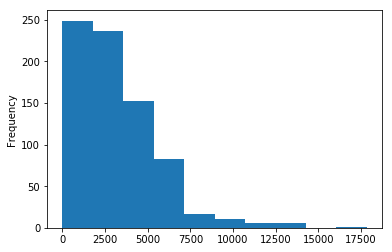

In [35]:
# The distribution of body length

news['bodylength'].plot(kind='hist')

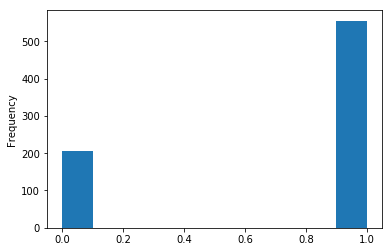

In [49]:
# The distribution of traditional structure in the body of the newsbody length

news['new_structure'].plot(kind='hist')

In [68]:
# How much false news has not the the traditional structure? How much true news?

len((news[(news['label'] == False) & (news['new_structure'] == 0)]))

181

In [ ]:
# How much true news?

In [69]:
len((news[(news['label'] == True) & (news['new_structure'] == 0)]))

26

In [70]:
# Has te same length false and true news?
news.groupby('label').agg({'bodylength': 'mean'})

,bodylength
label,
False,1820.377863
True,4051.934000


Preparing Text Data For Analysis

functions for cleaning, tokenizing, stemming and lemmatizing data and for deleting stop words

In [71]:
# function for cleaning

def clean_up_text(text):
    """
    The function cleans up numbers, remove punctuation and line break, and special characters from a string 
    and converts it to lowercase.

    Args:
        text: The string to be cleaned up.

    Returns:
        A string that has been cleaned up.
    """
    text = text.lower()
    text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)
    text = re.sub('\n', ' ', text) 
    text = re.sub('\w*\d\w*', '', text)    
    text = re.sub('[‘’“”…«»¿?¡!\-_\(\)]', '', text)
    text = re.sub(r'https?://(?:[-\w.]|(?:%[\da-fA-F]{2}))+', '', text)
  
    return text



In [72]:
# function for tokenizing

def tokenize_text(text):
        """
        Tokenize a string.

        Args:
            text: String to be tokenized.

        Returns:
            A list of words as the result of tokenization.
        """
        return word_tokenize(text)


In [73]:
# function for stemming, and lemmatizing

def stem_and_lemmatize(list_of_words):
    """
    Perform stemming and lemmatization on a list of words.

    Args:
        list_of_words: A list of strings.

    Returns:
        A list of strings after being stemmed and lemmatized.
    """
    stemmer = nltk.stem.SnowballStemmer('spanish')
    lemmatizer = WordNetLemmatizer()
    stemmed_lemmantized_list = [stemmer.stem(lemmatizer.lemmatize(word)) for word in list_of_words]
    return stemmed_lemmantized_list

In [74]:
# function for stops words

def remove_stopwords(list_of_words):
    """
    Remove English stopwords from a list of strings.

    Args:
        list_of_words: A list of strings.

    Returns:
        A list of strings after stop words are removed.
    """
    spanish_stop_words = stopwords.words('spanish')
      
    return [w for w in list_of_words if not w in spanish_stop_words]


Executing cleaning, tokenizing, stemming, lemmatizing and deleting stop words functions

In [75]:
# Cleaning
news['processed_body'] = news['body'].apply(lambda x: clean_up_text(str(x)))

In [76]:
# Stemming
news['processed_body'] = news['processed_body'].apply(tokenize_text)

In [77]:
# Lemmatizing
news['processed_body'] = news['processed_body'].apply(stem_and_lemmatize)

In [78]:
# Removing stop words
news['processed_body'] = news['processed_body'].apply(remove_stopwords)

In [79]:
# Visualizing the dataset
news.head()

,author,body,h1,h2,label,url,bodylength,new_structure,processed_body
0,empty,Ojalá una bomba ahora en Colón. ¿Donde están l...,"Pablo Iglesias borra un tuit: ""Ojalá una bomb...",empty,False,http://elmetropolitanodemadrid.blogspot.com/20...,84,0,"[ojal, bomb, ahor, colon, dond, estan, terror,..."
1,TransMurcia,En una comparecencia digna del Club de la Come...,El Partido Popular acapara el 86% del coste po...,empty,False,http://murciatransparente.net/partido-popular-...,2294,0,"[comparecent, dign, club, comedi, rafael, hern..."
2,empty,"Según informa el digital El Cadenazo, la alcal...",Manuela Carmena se ha convertido recientemente...,empty,False,http://www.12minutos.com/5c255a4e64b9a/manuela...,777,0,"[segun, inform, digital, cadenaz, alcaldes, ma..."
3,empty,Si en nuestra última noticia anunciábamos la p...,NUEVO RADAR DE TRAFICO INVISIBLE. COMPÁRTELO!,Llega a España el radar ‘invisible’. Tráfico p...,False,http://www.aldeaviral.com/nuevo-radar-de-trafi...,1133,0,"[si, nuestr, ultim, notici, anunci, propuest, ..."
4,Miguel Ruiz,"El líder del PP dice que ""haré lo posible para...",Pablo Casado: haré lo posible para impedir que...,empty,False,http://viraladvertising.over-blog.com/2018/11/...,564,0,"[lid, pp, dic, har, posibl, par, imped, salari..."


VISUAL ANALYSIS OF THE CORPUS (news['body'])

Wordcloud of the corpus(word frequency visualization. The size of the word in the image is bigger for more frequent word and smaller for less frequent word):

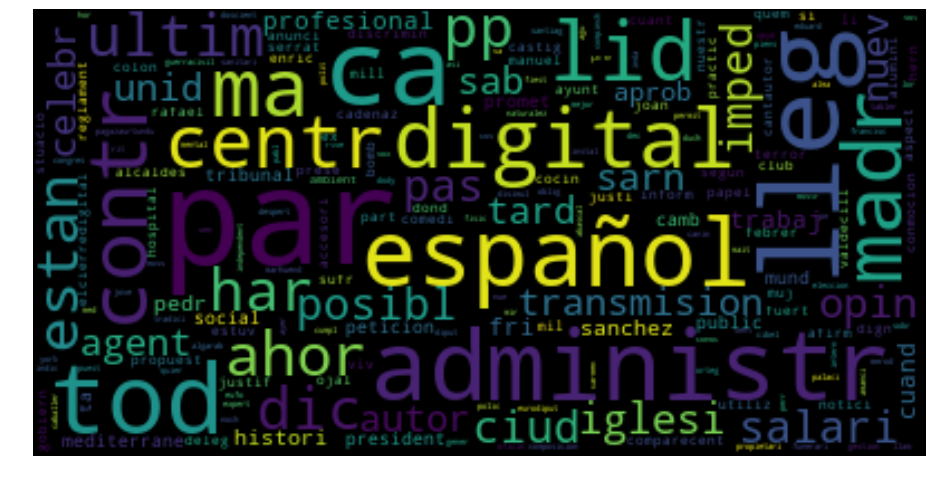

In [96]:
text = ''.join(x for x in str(news['processed_body']))
wordcloud = WordCloud(max_font_size=60).generate(text)
plt.figure(figsize=(16,12))
# plot wordcloud in matplotlib
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

Frequency distribution plot 

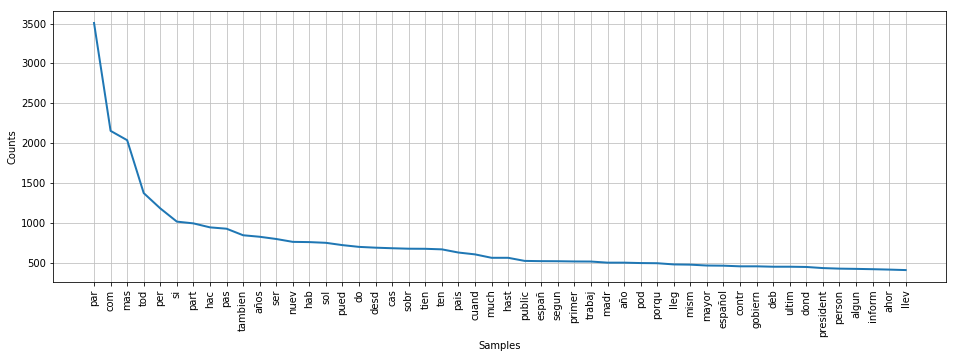

In [132]:

freqdist = nltk.FreqDist(word)
plt.figure(figsize=(16,5))
freqdist.plot(50)

In [131]:
# Frequency distribution plot of words by topic

topics = ['gobierno', 'inmigración', 'podemos', 'vox','ministro','pedro', 'prohibición']
word = news['processed_body'].sum()
freqdist = FreqDist(word)
for topic in topics:

    # print 5 most frequent words
    print(topic,'more :', ' , '.join([ word.lower() for word, count in freqdist.most_common(5)]))
    # print 5 least frequent words
    print(topic,'less :', ' , '.join([ word.lower() for word, count in freqdist.most_common()[-5:]]))
    


gobierno more : par , com , mas , tod , per
gobierno less : toxoalbumin , peoni , calaver , exsuegr , manriqu
inmigración more : par , com , mas , tod , per
inmigración less : toxoalbumin , peoni , calaver , exsuegr , manriqu
podemos more : par , com , mas , tod , per
podemos less : toxoalbumin , peoni , calaver , exsuegr , manriqu
vox more : par , com , mas , tod , per
vox less : toxoalbumin , peoni , calaver , exsuegr , manriqu
ministro more : par , com , mas , tod , per
ministro less : toxoalbumin , peoni , calaver , exsuegr , manriqu
pedro more : par , com , mas , tod , per
pedro less : toxoalbumin , peoni , calaver , exsuegr , manriqu
prohibición more : par , com , mas , tod , per
prohibición less : toxoalbumin , peoni , calaver , exsuegr , manriqu


CREATING MODEL FOR CLASSIFICATION

In the next cells we will build various models for news classification between fake or real news.

For this task, we will combine differente ways of processing text (vectorizer) with various classifiers.

Vectorizers: 

-ad hoc tokenization, stemming and lemmatization.

-vectorization by three different models: (TFIDF vectorizer, Countvectorizer and HashingVectorizer).

Classifiers: 
- Nltk.NaiveBayes.
- MultinomialNB
- PassiveAggresive.
- LogisticRegression.
- LinearSVC

So, we will test (by accuracy and confusion matrix) the next mixes of vectorizer and classficator:

1. Ad hoc + nltk.naivebayes
2. TFIDF + multinomialNB
3. Countvectorizer + multinomialNB.
4. TFIDF + PassiveAggresive.
5. HashingVectorizer + multinomialNB
6. HashingVectorizer + PassiveAggresive.
7. Countvectorizer + LogisticRegression.
8. TFIDF + LogisticRegression.
9. Countvectorizer + LinearSVC.
10. Countvectorizer + LinearSVC with 3 ngrams.

Finally, we will choose the mix with better combination.

1. Ad hoc + nltk.naivebayes


Ad hoc tokenization, stemming and lemmatization:

Creating Bag of Words.
 The bag of words contains all the unique words in your whole text body

In [144]:
# Creating a bag of words from the processed data.


bag_of_words = []
for word in news.processed_body:
    bag_of_words += word



Building Features

    Using the top 5,000 words, we create a diccionary to record whether each of those words is    
    contained in each document (new's text). 
    Nest to the dicctionary, we add the label is True o False.
    So, we get a set with a dictionary and the label.

In [145]:
# Selecting the most important words to build the features with NLTK's FreqDist

# Calling Freqdist()

fdist = FreqDist(bag_of_words)


# Selecting the top 5,000 words from the frequency distribution with most_common().

selected = fdist.most_common(10000)

top_words = [x[0] for x in selected]


In [146]:
# Function to generate the features and label tuple.

def find_features(text_of_new, label):
    words = set(text_of_new)
    features = {}
    for w in top_words:
        features[w] = (w in words)
    result = label
    return (features, result)

In [147]:
# find_features() execution on news' text

features = list(news.apply(lambda x: find_features(x['processed_body'], x['label']), axis=1))


#Accuracy with the original dataset (only 60 false news + 60 true news)

train_set, test_set = features[:48] + features[60:108], features[48:60] + features[108:]
classifier = nltk.NaiveBayesClassifier.train(train_set)
print("Classifier accuracy percent:",(nltk.classify.accuracy(classifier, test_set))*100)
Classifier accuracy percent: 58.333333333333336


#train_set, test_set = features[:48] + features[60:108], features[48:60] + features[108:]

    # 209 y 53 falsas, 400 y 100 verdaderas
    # train_set = 209 falsas y 400 verdaderas
    # test_set = 53 falsas y 100 verdaderas

X, y = features[:][0], features[:][1]
features_true = [feature for feature in features if feature[1] == True]
features_false = [feature for feature in features if feature[1] == False]


In [151]:
#train_set, test_set = random.sample(features_true, 50) + random.sample(features_false, 183), 
#random.sample(the_list, 50) + random.sample(the_list, 50) 


random.shuffle(features_true)
random.shuffle(features_false)

train_set, test_set = features_true[:400] + features_false[:209], features_true[400:] + features_false[209:]


In [152]:
classifier = nltk.NaiveBayesClassifier.train(train_set)
print("Classifier accuracy percent:",(nltk.classify.accuracy(classifier, test_set))*100)


Classifier accuracy percent: 86.27450980392157


In [153]:
#testing = test_set[0][0]
true_labels = []
predicted_labels = []
for element in test_set:
    true_labels.append(element[1])
    predicted_labels.append(classifier.classify(element[0]))
confusion_df = pd.DataFrame({'True_label': true_labels,'Predicted_label': predicted_labels})


In [154]:
cm = nltk.ConfusionMatrix(true_labels, predicted_labels)
print(cm)

      |  F    |
      |  a  T |
      |  l  r |
      |  s  u |
      |  e  e |
------+-------+
False |<48> 5 |
 True | 16<84>|
------+-------+
(row = reference; col = test)



In [273]:
# Defining true positives, false positives and false negatives
TP = cm[1,1]
FP = cm[0,1]
FN = cm[1,0]

In [274]:
#Precision, which indicates how many of the items that we identified were relevant, is TP/(TP+FP).
precision = TP/(TP+FP)
print('Preccision: ', precision) 

#Recall, which indicates how many of the relevant items that we identified, is TP/(TP+FN).
recall = TP/(TP+FN)
print('Recall: ', recall) 

#The F-Measure (or F-Score), which combines the precision and recall to give a single score, 
#is defined to be the harmonic mean of the precision and recall: 
#(2 × Precision × Recall) / (Precision + Recall).
f_score= (2 * precision * recall) / (precision + recall)
print('F-score: ', f_score)


Preccision:  0.8918918918918919
Recall:  0.66
F-score:  0.7586206896551725


In [155]:
# Showing the most informative features for this model.
classifier.show_most_informative_features()

Most Informative Features
                     abc = True             True : False  =     13.8 : 1.0
                 mantien = True             True : False  =     12.7 : 1.0
                   anunc = True             True : False  =     12.4 : 1.0
                       € = True            False : True   =     12.1 : 1.0
                 complej = True             True : False  =     10.3 : 1.0
                  fallec = True             True : False  =     10.0 : 1.0
                   entid = True             True : False  =      9.6 : 1.0
                   cierr = True             True : False  =      9.3 : 1.0
                pendient = True             True : False  =      9.3 : 1.0
                   ambit = True             True : False  =      8.9 : 1.0


#For the newt models, we can usse train_test_split:

In [156]:
# Extracting the training data
X_train, X_test, y_train, y_test = train_test_split((news['body'].apply(lambda x: clean_up_text(str(x)))), news['label'], test_size=0.33, random_state=53)


In [157]:
# For the next vectorizer, we create a spanish stop_words list.

spanish = ['de', 'la', 'que', 'el', 'en', 'y', 'a', 'los', 'del', 'se', 'las','por','un',
'para','con','no','una','su','al','lo','como','más','pero','sus','le','ya','o','este','sí','porque''esta','entre','cuando','muy','sin','sobre',
'también','me','hasta','hay','donde','quien','desde','todo','nos','durante','todos','uno','les','ni','contra',
'otros','ese','eso','ante','ellos','e','esto','mí','antes','algunos','qué','unos','yo','otro',
'otras','otra','él','tanto','esa','estos','mucho','quienes','nada','muchos','cual','poco','ella','estar',
'estas','algunas','algo','nosotros','mi','mis','tú','te','ti','tu','tus','ellas','nosotras',
'vosostros','vosostras','os','mío','mía','míos','mías','tuyo','tuya','tuyos','tuyas','suyo','suya','suyos',
'suyas','nuestro','nuestra','nuestros','nuestras','vuestro','vuestra','vuestros','vuestras','esos','esas','estoy',
'estás','está','estamos','estáis','están','esté','estés','estemos','estéis','estén','estaré','estarás',
'estará','estaremos','estaréis','estarán','estaría','estarías',
'estaríamos','estaríais','estarían','estaba','estabas','estábamos','estabais','estaban','estuve','estuviste','estuvo','estuvimos',
'estuvisteis','estuvieron','estuviera','estuvieras','estuviéramos','estuvierais','estuvieran','estuviese','estuvieses',
'estuviésemos','estuvieseis','estuviesen','estando','estado','estada','estados',
'estadas','estad','he','has','ha','hemos','habéis','han','haya','hayas','hayamos','hayáis','hayan',
'habré','habrás','habrá','habremos','habréis','habrán','habría','habrías','habríamos','habríais',
'habrían','había','habías','habíamos','habíais','habían','hube','hubiste','hubo','hubimos','hubisteis',
'hubieron','hubiera','hubieras','hubiéramos','hubierais','hubieran','hubiese','hubieses','hubiésemos',
'hubieseis','hubiesen','habiendo','habido','habida','habidos','habidas','soy','eres','es','somos','sois',
'son','sea','seas','seamos','seáis','sean','seré','serás','será','seremos','seréis','serán','sería',
'serías','seríamos','seríais','serían','era','eras','éramos','erais','eran','fui','fuiste','fue','fuimos',
'fuisteis','fueron','fuera','fueras','fuéramos','fuerais','fueran','fuese','fueses','fuésemos','fueseis',
'fuesen','sintiendo','sentido','sentida','sentidos','sentidas','siente','sentid','tengo','tienes',
'tiene','tenemos','tenéis','tienen','tenga','tengas','tengamos','tengáis','tengan','tendré',
'tendrás','tendrá','tendremos','tendréis','tendrán','tendría','tendrías','tendríamos',
'tendríais','tendrían','tenía','tenías','teníamos','teníais','tenían','tuve','tuviste','tuvo','tuvimos',
'tuvisteis','tuvieron','tuviera','tuvieras','tuviéramos','tuvierais','tuvieran','tuviese','tuvieses',
'tuviésemos','tuvieseis','tuviesen','teniendo','tenido','tenida','tenidos','tenidas','tened']



TFIDF + COUNT VECTORIZATION

In [158]:
# Initialize the `count_vectorizer` 
count_vectorizer = CountVectorizer(stop_words=spanish)


In [159]:
# Fit and transform the training data 
count_train = count_vectorizer.fit_transform(X_train) 

In [160]:
# Transform the test set 
count_test = count_vectorizer.transform(X_test)

In [161]:
# Initialize the `tfidf_vectorizer` 
tfidf_vectorizer = TfidfVectorizer(stop_words=spanish, max_df=0.7) 


In [162]:
# Fit and transform the training data 
tfidf_train = tfidf_vectorizer.fit_transform(X_train) 

In [163]:
# Transform the test set 
tfidf_test = tfidf_vectorizer.transform(X_test)

In [164]:
# Get the feature names of `tfidf_vectorizer` 
print(tfidf_vectorizer.get_feature_names()[-10:])

['única', 'únicamente', 'únicas', 'únicla', 'único', 'únicos', 'úsalo', 'útero', 'útil', 'útiles']


In [165]:
# Get the feature names of `count_vectorizer` 
print(count_vectorizer.get_feature_names()[:10])

['aalbersberg', 'ab', 'abadía', 'abajo', 'abanca', 'abanderados', 'abandona', 'abandonada', 'abandonadas', 'abandonado']


Count versus TF-IDF Features

In [167]:
count_df = pd.DataFrame(count_train.A, columns=count_vectorizer.get_feature_names())



In [168]:
tfidf_df = pd.DataFrame(tfidf_train.A, columns=tfidf_vectorizer.get_feature_names())



In [170]:
print(count_df.equals(tfidf_df))



False


In [294]:
count_df.head()

,aalbersberg,ab,abadía,abajo,abanca,abanderados,abandona,abandonada,abandonadas,abandonado,...,única,únicamente,únicas,únicla,único,únicos,úsalo,útero,útil,útiles
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [172]:
tfidf_df.head()

,aalbersberg,ab,abadía,abajo,abanca,abanderados,abandona,abandonada,abandonadas,abandonado,...,única,únicamente,únicas,únicla,único,únicos,úsalo,útero,útil,útiles
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.032205,0.000000,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.035274,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0


Defining function to plot confusion matrix for comparing models 

In [175]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    Input: confusion matrix
    Output: the functionprints and plots the confusion matrix.
    
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

2. TFIDF + multinomialNB

accuracy:   0.659
Confusion matrix


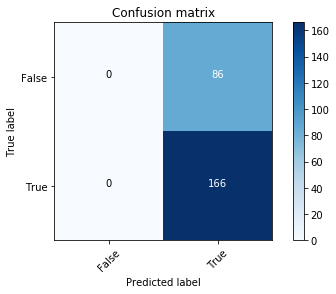

In [176]:

clf = MultinomialNB() 


clf.fit(tfidf_train, y_train)
pred = clf.predict(tfidf_test)
score = sklearn.metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = sklearn.metrics.confusion_matrix(y_test, pred, labels=[False, True])
plot_confusion_matrix(cm, classes=[False, True])

3. Countvectorizer + multinomialNB.

accuracy:   0.790
Confusion matrix


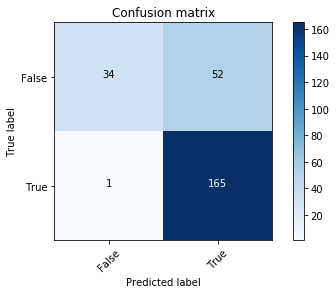

In [177]:

clf = MultinomialNB() 

clf.fit(count_train, y_train)
pred = clf.predict(count_test)
score = sklearn.metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = sklearn.metrics.confusion_matrix(y_test, pred, labels=[False, True])
plot_confusion_matrix(cm, classes=[False, True])

4. TFIDF + PassiveAggresive:

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning:

n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning:

n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.



accuracy:   0.849
Confusion matrix


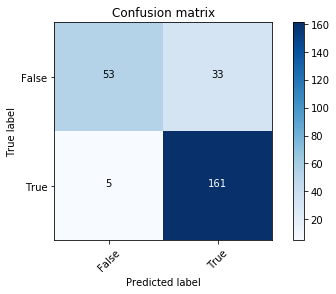

In [178]:

linear_clf = PassiveAggressiveClassifier(n_iter=50)
linear_clf.fit(tfidf_train, y_train)
pred = linear_clf.predict(tfidf_test)
score = sklearn.metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = sklearn.metrics.confusion_matrix(y_test, pred, labels=[False, True])
plot_confusion_matrix(cm, classes=[False, True])

test if tuning the alpha value for a MultinomialNB:

In [179]:
clf = MultinomialNB(alpha=0.1)

last_score = 0
for alpha in np.arange(0,1,.1):
    nb_classifier = MultinomialNB(alpha=alpha)
    nb_classifier.fit(tfidf_train, y_train)
    pred = nb_classifier.predict(tfidf_test)
    score = sklearn.metrics.accuracy_score(y_test, pred)
    if score > last_score:
        clf = nb_classifier
    print("Alpha: {:.2f} Score: {:.5f}".format(alpha, score))

    clf = MultinomialNB(alpha=0.1)

last_score = 0
for alpha in np.arange(0,1,.1):
    nb_classifier = MultinomialNB(alpha=alpha)
    nb_classifier.fit(tfidf_train, y_train)
    pred = nb_classifier.predict(tfidf_test)
    score = sklearn.metrics.accuracy_score(y_test, pred)
    if score > last_score:
        clf = nb_classifier
    print("Alpha: {:.2f} Score: {:.5f}".format(alpha, score))

Alpha: 0.00 Score: 0.72619
Alpha: 0.10 Score: 0.80159
Alpha: 0.20 Score: 0.71032
Alpha: 0.30 Score: 0.69048
Alpha: 0.40 Score: 0.68254
Alpha: 0.50 Score: 0.67857
Alpha: 0.60 Score: 0.67460
Alpha: 0.70 Score: 0.66667
Alpha: 0.80 Score: 0.66667
Alpha: 0.90 Score: 0.66270
Alpha: 0.00 Score: 0.72619
Alpha: 0.10 Score: 0.80159
Alpha: 0.20 Score: 0.71032
Alpha: 0.30 Score: 0.69048
Alpha: 0.40 Score: 0.68254
Alpha: 0.50 Score: 0.67857
Alpha: 0.60 Score: 0.67460
Alpha: 0.70 Score: 0.66667
Alpha: 0.80 Score: 0.66667
Alpha: 0.90 Score: 0.66270


/usr/local/lib/python3.6/dist-packages/sklearn/naive_bayes.py:480: UserWarning:

alpha too small will result in numeric errors, setting alpha = 1.0e-10

/usr/local/lib/python3.6/dist-packages/sklearn/naive_bayes.py:480: UserWarning:

alpha too small will result in numeric errors, setting alpha = 1.0e-10



Introspecting models

In [180]:
def most_informative_feature_for_binary_classification(vectorizer, classifier, n=100):
    """
    
    Identify most important features if given a vectorizer and binary classifier. Set n to the number
    of weighted features you would like to show. (Note: current implementation merely prints and does not 
    return top classes.)
    """

    class_labels = classifier.classes_
    feature_names = vectorizer.get_feature_names()
    topn_class1 = sorted(zip(classifier.coef_[0], feature_names))[:n]
    topn_class2 = sorted(zip(classifier.coef_[0], feature_names))[-n:]

    for coef, feat in topn_class1:
        print(class_labels[0], coef, feat)

    print()

    for coef, feat in reversed(topn_class2):
        print(class_labels[1], coef, feat)

In [181]:
most_informative_feature_for_binary_classification(tfidf_vectorizer, linear_clf, n=30)


False -1.4390431183106593 iglesias
False -1.283541755345842 inmigrantes
False -1.1295540178574284 podemos
False -1.0691990834843228 español
False -1.0400812178253658 cabo
False -1.0319563287479003 iglesia
False -0.9840691344896436 gatorade
False -0.944538348571161 empty
False -0.9409440897804732 jugadores
False -0.9398536222579918 presos
False -0.8674642253651011 españoles
False -0.8672073002366197 llevan
False -0.8585045872071934 real
False -0.8565731653502308 florentino
False -0.8446973234237325 documental
False -0.8336617321834366 concurso
False -0.8317037417193404 canción
False -0.830946658733051 sanidad
False -0.8219058643396977 ayudas
False -0.8166443145205078 noche
False -0.8103816209330273 vox
False -0.8020976293427629 marroquíes
False -0.7955513654587818 pareja
False -0.7806144782779726 dem
False -0.7787493944714109 sorpresa
False -0.7695966019883005 comida
False -0.7674311579848332 feminista
False -0.766458642454684 ayuntamiento
False -0.7649418621558999 españa
False -0.76074

zipping coefficients to  features and taking a look at the top and bottom of the list:


In [305]:
feature_names = tfidf_vectorizer.get_feature_names()

In [306]:
### Most real
sorted(zip(clf.coef_[0], feature_names), reverse=True)[:20]

[(-8.238432851475594, 'años'),
 (-8.397769083892129, 'dos'),
 (-8.406687976294052, 'si'),
 (-8.495951450682584, 'esta'),
 (-8.56662432283884, 'millones'),
 (-8.590947153350701, 'presidente'),
 (-8.625977841457033, 'gobierno'),
 (-8.629815370489615, 'españa'),
 (-8.63239430012026, 'porque'),
 (-8.637681198137656, 'año'),
 (-8.638119663431887, 'según'),
 (-8.643133370195525, 'pasado'),
 (-8.643990147613568, 'país'),
 (-8.65755104192289, 'parte'),
 (-8.657643201650625, 'tras'),
 (-8.65853358954905, 'madrid'),
 (-8.69584825118156, 'hace'),
 (-8.739926501765886, 'ser'),
 (-8.742410728454091, 'después'),
 (-8.744056695152782, 'solo')]

In [307]:
### Most fake
sorted(zip(clf.coef_[0], feature_names))[:20]

[(-10.368754638525337, 'abandonará'),
 (-10.368754638525337, 'abandone'),
 (-10.368754638525337, 'abaratarán'),
 (-10.368754638525337, 'abasto'),
 (-10.368754638525337, 'abdelhafid'),
 (-10.368754638525337, 'abdelkrim'),
 (-10.368754638525337, 'abducidas'),
 (-10.368754638525337, 'aberrantes'),
 (-10.368754638525337, 'abochornante'),
 (-10.368754638525337, 'abogó'),
 (-10.368754638525337, 'abolida'),
 (-10.368754638525337, 'abolido'),
 (-10.368754638525337, 'abona'),
 (-10.368754638525337, 'abonado'),
 (-10.368754638525337, 'abortos'),
 (-10.368754638525337, 'abracen'),
 (-10.368754638525337, 'abraham'),
 (-10.368754638525337, 'abrazos'),
 (-10.368754638525337, 'abriré'),
 (-10.368754638525337, 'abrumadora')]

 5. Hashvectorizer + Multinomial

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/hashing.py:102: DeprecationWarning:

the option non_negative=True has been deprecated in 0.19 and will be removed in version 0.21.

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/hashing.py:102: DeprecationWarning:

the option non_negative=True has been deprecated in 0.19 and will be removed in version 0.21.

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/hashing.py:102: DeprecationWarning:

the option non_negative=True has been deprecated in 0.19 and will be removed in version 0.21.



accuracy:   0.683
Confusion matrix


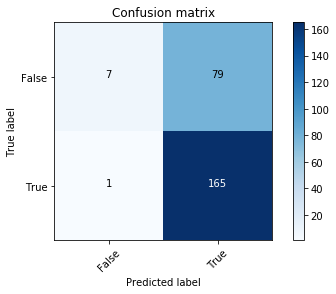

In [183]:
hash_vectorizer = HashingVectorizer(stop_words=spanish, non_negative=True)

hash_train = hash_vectorizer.fit_transform(X_train)
hash_test = hash_vectorizer.transform(X_test)
clf = MultinomialNB(alpha=.01)
clf.fit(hash_train, y_train)
pred = clf.predict(hash_test)
score = sklearn.metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = sklearn.metrics.confusion_matrix(y_test, pred, labels=[False, True])
plot_confusion_matrix(cm, classes=[False, True])

6. HashVectorizer + passive_aggressive

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


accuracy:   0.861
Confusion matrix, without normalization


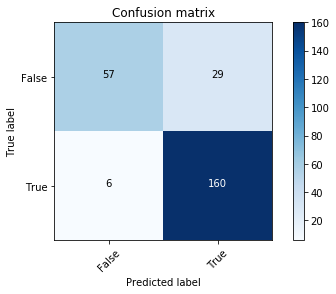

In [310]:
# Another test:
clf = PassiveAggressiveClassifier(n_iter=50)
clf.fit(hash_train, y_train)
pred = clf.predict(hash_test)
score = sklearn.metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = sklearn.metrics.confusion_matrix(y_test, pred, labels=[False, True])
plot_confusion_matrix(cm, classes=[False, True])

7. Countvectorizer + LogisticRegression.

In [184]:

ngram_vectorizer = CountVectorizer(binary=True, ngram_range=(1, 2))
ngram_vectorizer.fit((news['body'].apply(lambda x: clean_up_text(str(x)))))
X = ngram_vectorizer.transform((news['body'].apply(lambda x: clean_up_text(str(x)))))
#X_test = ngram_vectorizer.transform(sentencesTest)

X_train, X_test, y_train, y_test = train_test_split(
    X, news['label'], train_size = 0.71
)

for c in [0.01, 0.05, 0.25, 0.5, 1]:
    
    lr = LogisticRegression(C=c)
    lr.fit(X_train, y_train)
    print ("Accuracy for C=%s: %s" % (c, accuracy_score(y_test, lr.predict(X_test))))

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:2179: FutureWarning:

From version 0.21, test_size will always complement train_size unless both are specified.

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.



Accuracy for C=0.01: 0.8280542986425339
Accuracy for C=0.05: 0.8552036199095022
Accuracy for C=0.25: 0.8506787330316742
Accuracy for C=0.5: 0.8506787330316742
Accuracy for C=1: 0.8506787330316742


In [185]:
final_ngram = LogisticRegression(C=1) 
final_ngram.fit(X_train, y_train)
print ("Final Accuracy: %s" % accuracy_score(y_test, final_ngram.predict(X_test)))

Final Accuracy: 0.8506787330316742


Confusion matrix


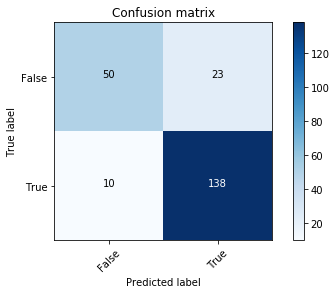

In [189]:

pred = final_ngram.predict(X_test)
cm = sklearn.metrics.confusion_matrix(y_test, pred, labels=[False, True])
plot_confusion_matrix(cm, classes=[False, True])

8. TFIDF + LogisticRegression.

In [190]:
tfidf_vectorizer = TfidfVectorizer()
tfidf_vectorizer.fit((news['body'].apply(lambda x: clean_up_text(str(x)))))
X = tfidf_vectorizer.transform((news['body'].apply(lambda x: clean_up_text(str(x)))))
#X_test = tfidf_vectorizer.transform(sentencesTest)

X_train, X_test, y_train, y_test = train_test_split(
    X, news['label'], train_size = 0.71
)

for c in [0.01, 0.05, 0.25, 0.5, 1]:
    
    lr = LogisticRegression(C=c)
    lr.fit(X_train, y_train)
    print ("Accuracy for C=%s: %s" 
           % (c, accuracy_score(y_test, lr.predict(X_test))))

Accuracy for C=0.01: 0.6199095022624435
Accuracy for C=0.05: 0.6199095022624435
Accuracy for C=0.25: 0.6289592760180995
Accuracy for C=0.5: 0.6425339366515838
Accuracy for C=1: 0.7149321266968326


In [191]:
final_tfidf = LogisticRegression(C=1)
final_tfidf.fit(X_train, y_train)
print ("Final Accuracy: %s" 
       % accuracy_score(y_test, final_tfidf.predict(X_test)))

Final Accuracy: 0.7149321266968326


Confusion matrix


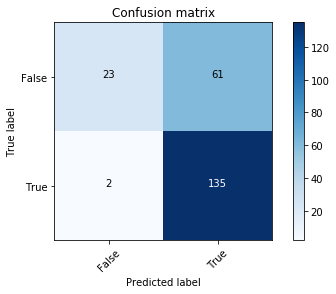

In [192]:
pred = final_tfidf.predict(X_test)

cm = sklearn.metrics.confusion_matrix(y_test, pred, labels=[False, True])
plot_confusion_matrix(cm, classes=[False, True])

9. Countvectorizer + LinearSVC.

In [193]:

ngram_vectorizer = CountVectorizer(stop_words=spanish, binary=True, ngram_range=(1, 2))
ngram_vectorizer.fit((news['body'].apply(lambda x: clean_up_text(str(x)))))
X = ngram_vectorizer.transform((news['body'].apply(lambda x: clean_up_text(str(x)))))
#X_test = ngram_vectorizer.transform(sentencesTest)

X_train, X_test, y_train, y_test = train_test_split(
    X, news['label'], train_size = 0.71
)

for c in [0.01, 0.05, 0.25, 0.5, 1]:
    
    svm = LinearSVC(C=c)
    svm.fit(X_train, y_train)
    print ("Accuracy for C=%s: %s" % (c, accuracy_score(y_test, svm.predict(X_test))))

Accuracy for C=0.01: 0.9230769230769231
Accuracy for C=0.05: 0.918552036199095
Accuracy for C=0.25: 0.9140271493212669


/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



Accuracy for C=0.5: 0.918552036199095
Accuracy for C=1: 0.918552036199095


In [194]:
final_svm_ngram = LinearSVC(C=0.05)
final_svm_ngram.fit(X_train, y_train)
print ("Final Accuracy: %s" 
       % accuracy_score(y_test, final_svm_ngram.predict(X_test)))

Final Accuracy: 0.918552036199095


Confusion matrix


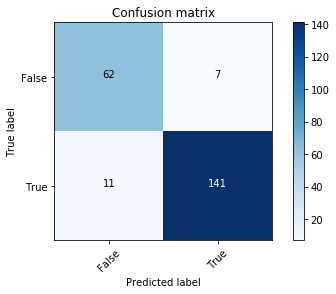

In [196]:
pred = final_svm_ngram.predict(X_test)
cm = sklearn.metrics.confusion_matrix(y_test, pred, labels=[False, True])
plot_confusion_matrix(cm, classes=[False, True])

In [197]:
# Count + SVC + n_gram_range: 3

ngram_vectorizer = CountVectorizer(binary=True, ngram_range=(1, 3))
ngram_vectorizer.fit((news['body'].apply(lambda x: clean_up_text(str(x)))))
X = ngram_vectorizer.transform((news['body'].apply(lambda x: clean_up_text(str(x)))))
#X_test = ngram_vectorizer.transform(sentencesTest)

X_train, X_test, y_train, y_test = train_test_split(
    X, news['label'], train_size = 0.71
)

for c in [0.001, 0.005, 0.01, 0.05, 0.1,0.5,1]:
    
    svm = LinearSVC(C=c)
    svm.fit(X_train, y_train)
    print ("Accuracy for C=%s: %s" % (c, accuracy_score(y_test, svm.predict(X_test))))

Accuracy for C=0.001: 0.9049773755656109
Accuracy for C=0.005: 0.9004524886877828
Accuracy for C=0.01: 0.8914027149321267
Accuracy for C=0.05: 0.8914027149321267
Accuracy for C=0.1: 0.8914027149321267
Accuracy for C=0.5: 0.8959276018099548
Accuracy for C=1: 0.8959276018099548


In [198]:
final = LinearSVC(C=0.005)
final.fit(X_train, y_train)
print ("Final Accuracy: %s" 
       % accuracy_score(y_test, final.predict(X_test)))

Final Accuracy: 0.9004524886877828


Confusion matrix


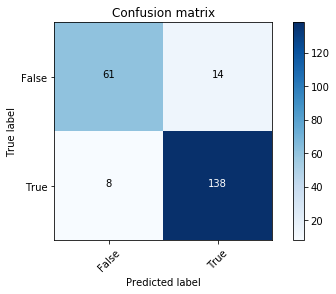

In [199]:
pred = final.predict(X_test)
cm = sklearn.metrics.confusion_matrix(y_test, pred, labels=[False, True])
plot_confusion_matrix(cm, classes=[False, True])

SELECTION AND SAVING THE MODEL

The are the result of the accuracy for each model:
    1. Ad hoc + nltk.naivebayes: 0.7254901960784314
    2. TFIDF + multinomialNB   0.659
    3. Countvectorizer + multinomialNB.  0.790
    4. TFIDF + PassiveAggresive: 0.849
    5. HashingVectorizer + multinomialNB: 0.683
    6. HashVectorizer + passive_aggressive 0.861
     7. Countvectorizer + LogisticRegression.0.8506787330316742
    8. TFIDF + LogisticRegression: 0.7149321266968326
    9. Countvectorizer + LinearSVC:  0.918552036199095
    10. Count + SVC + n_gram_range: 0.9004524886877828
After various test, these are representative, except the for the number 10 model.

In fact, wh select the 10 model for his regular and stable results.

In this selection, we have analyzed the confusion matrix too.

So in the newt cells, we save this model with his vectorizer, for a future app.

In [16]:
# save the model to disk: 

filename = 'finalized_model.sav'
pickle.dump(svm, open(filename, 'wb'))

In [ ]:
# Loading the model
'''
filename = 'finalized_model.sav'
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, Y_test)
'''

In [34]:
# save the vectorizer to disk: 

filename2 = 'finalized_vectorizer.sav'
pickle.dump(ngram_vectorizer, open(filename2, 'wb'))